In [1]:
from collections import defaultdict
import math
import os
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import PIL
import pyprojroot
import seaborn as sns
import torchvision

import searchnets

In [2]:
VSD_2012_ROOT = Path('/home/bart/Documents/data/voc/VOCdevkit/VOC2012')

In [3]:
parse_xml = searchnets.transforms.ParseVocXml()

def _plot_row(vsd_df_row, ax, target_label, vsd_root=VSD_2012_ROOT, target_color='red', distractor_color='green'):
    img = PIL.Image.open(
        vsd_root / vsd_df_row.img_file
    )
    annot = parse_xml(vsd_root / vsd_df_row.xml_file)
    ax.imshow(img)
    object_list = annot['annotation']['object']
    if isinstance(object_list, dict):
        object_list = [object_list]
    for object_ in object_list:
        label, bndbox = object_['name'], object_['bndbox']
        bndbox = {k: int(v) for k, v in bndbox.items()}
        if label == target_label:
            edgecolor = target_color
        else:
            edgecolor = distractor_color
        xy = (bndbox['xmin'], bndbox['ymin'])
        width = bndbox['xmax'] - bndbox['xmin']
        height = bndbox['ymax'] - bndbox['ymin']
        rect = patches.Rectangle(xy, width, height, linewidth=2, edgecolor=edgecolor, facecolor='none')
        ax.add_patch(rect)
    
def plot_class_examples(vsd_df, class_label_str, n_examples=4, figsize=(5, 5), dpi=150):
    has_class_label = vsd_df['labels_str'].apply(lambda labels_str_list: class_label_str in labels_str_list)
    df_class = vsd_df[has_class_label]

    n_rows_cols = math.ceil(math.sqrt(n_examples))
    fig, ax_arr = plt.subplots(n_rows_cols, n_rows_cols, figsize=figsize, dpi=dpi)
    
    examples = df_class.sample(n_examples)
    for ax, example in zip(ax_arr.ravel(), examples.itertuples()):
        _plot_row(example, ax, class_label_str)
        ax.set_axis_off()

    return fig, ax_arr
    

#### Add "set size" to VSD / Pascal VOC dataset .csv
using the number of annotated bounding boxes as a proxy for set size

In [4]:
vsd_split_csv = pyprojroot.here() / 'data/Visual_Search_Difficulty_v1.0/VSD_dataset_split.csv'

In [5]:
vsd_df = pd.read_csv(vsd_split_csv)

add set size to VSD split csv

In [6]:
image_dir = VSD_2012_ROOT / 'JPEGImages'
annotation_dir = VSD_2012_ROOT / 'Annotations'

In [7]:
vsd_df['root_output_dir'] = str(VSD_2012_ROOT)

In [8]:
vsd_df['img_file'] = ['JPEGImages/' + file_name + ".jpg" for file_name in vsd_df['img'].values]

In [9]:
vsd_df['meta_file'] = 'none'

In [10]:
vsd_df['xml_file'] = ['Annotations/' + file_name + ".xml" for file_name in vsd_df['img'].values]

In [11]:
target_transform = torchvision.transforms.Compose(
    [searchnets.transforms.ParseVocXml(),
     searchnets.transforms.ClassIntsFromXml()]
)

In [12]:
vsd_df['xml_path'] = vsd_df['root_output_dir'] + '/' + vsd_df['xml_file']

In [13]:
vsd_df['labels'] = vsd_df.xml_path.apply(target_transform)

In [14]:
vsd_df['set_size'] = vsd_df.labels.apply(len)

In [15]:
VOC_CLASSES = (
    'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor')

VOC_CLASS_INT_MAP = dict(zip(VOC_CLASSES, range(len(VOC_CLASSES))))
VOC_INT_CLASS_MAP = dict(zip(range(len(VOC_CLASSES)), VOC_CLASSES))

In [16]:
vsd_df['labels_str'] = vsd_df['labels'].map(
    lambda labels_int_list: [VOC_INT_CLASS_MAP[label_int] for label_int in labels_int_list]
)

#### Now compute number of images for each set size, on a per-class basis

In [17]:
count_records = []
records = []

for label in range(20):
    label_as_set = {label}
    df_label = vsd_df[vsd_df.labels.apply(lambda x: bool(label_as_set.intersection(x)))]
    count_records.append(
        {
            'label_int': label,
            'label_str': VOC_INT_CLASS_MAP[label],
            'n_rows': len(df_label)
        }
    )
    set_sizes = df_label.set_size.values
    uniq_set_sizes, counts = np.unique(set_sizes, return_counts=True)
    for set_size, count in zip(uniq_set_sizes, counts):
        records.append(
            {
                'label_int': label,
                'label_str': VOC_INT_CLASS_MAP[label],
                'set_size': set_size,
                'count': count
            }
        )

df_label_rows = pd.DataFrame.from_records(count_records)
df_label_set_size = pd.DataFrame.from_records(records)

#### Finally rank classes by the number of times they occur
If we use the $k$ most frequently occuring number of classes (for some $k$), we should be able to get an estimate of how much models behave when each class is treated as a target, without running into severe class imbalance issues

Looks like 5 is a good value for $k$, and the plot above suggests this will give us a good distribution of set sizes across classes.

In [18]:
N_CLASSES = 5

order = df_label_rows.sort_values('n_rows', ascending=False).label_str.values

these_class_labels = order[:N_CLASSES]

data_for_plot = df_label_set_size[
    (df_label_set_size.label_str.isin(these_class_labels)) &
    (df_label_set_size.set_size < 7)
]

#### Plot count of images for each set size, per-class

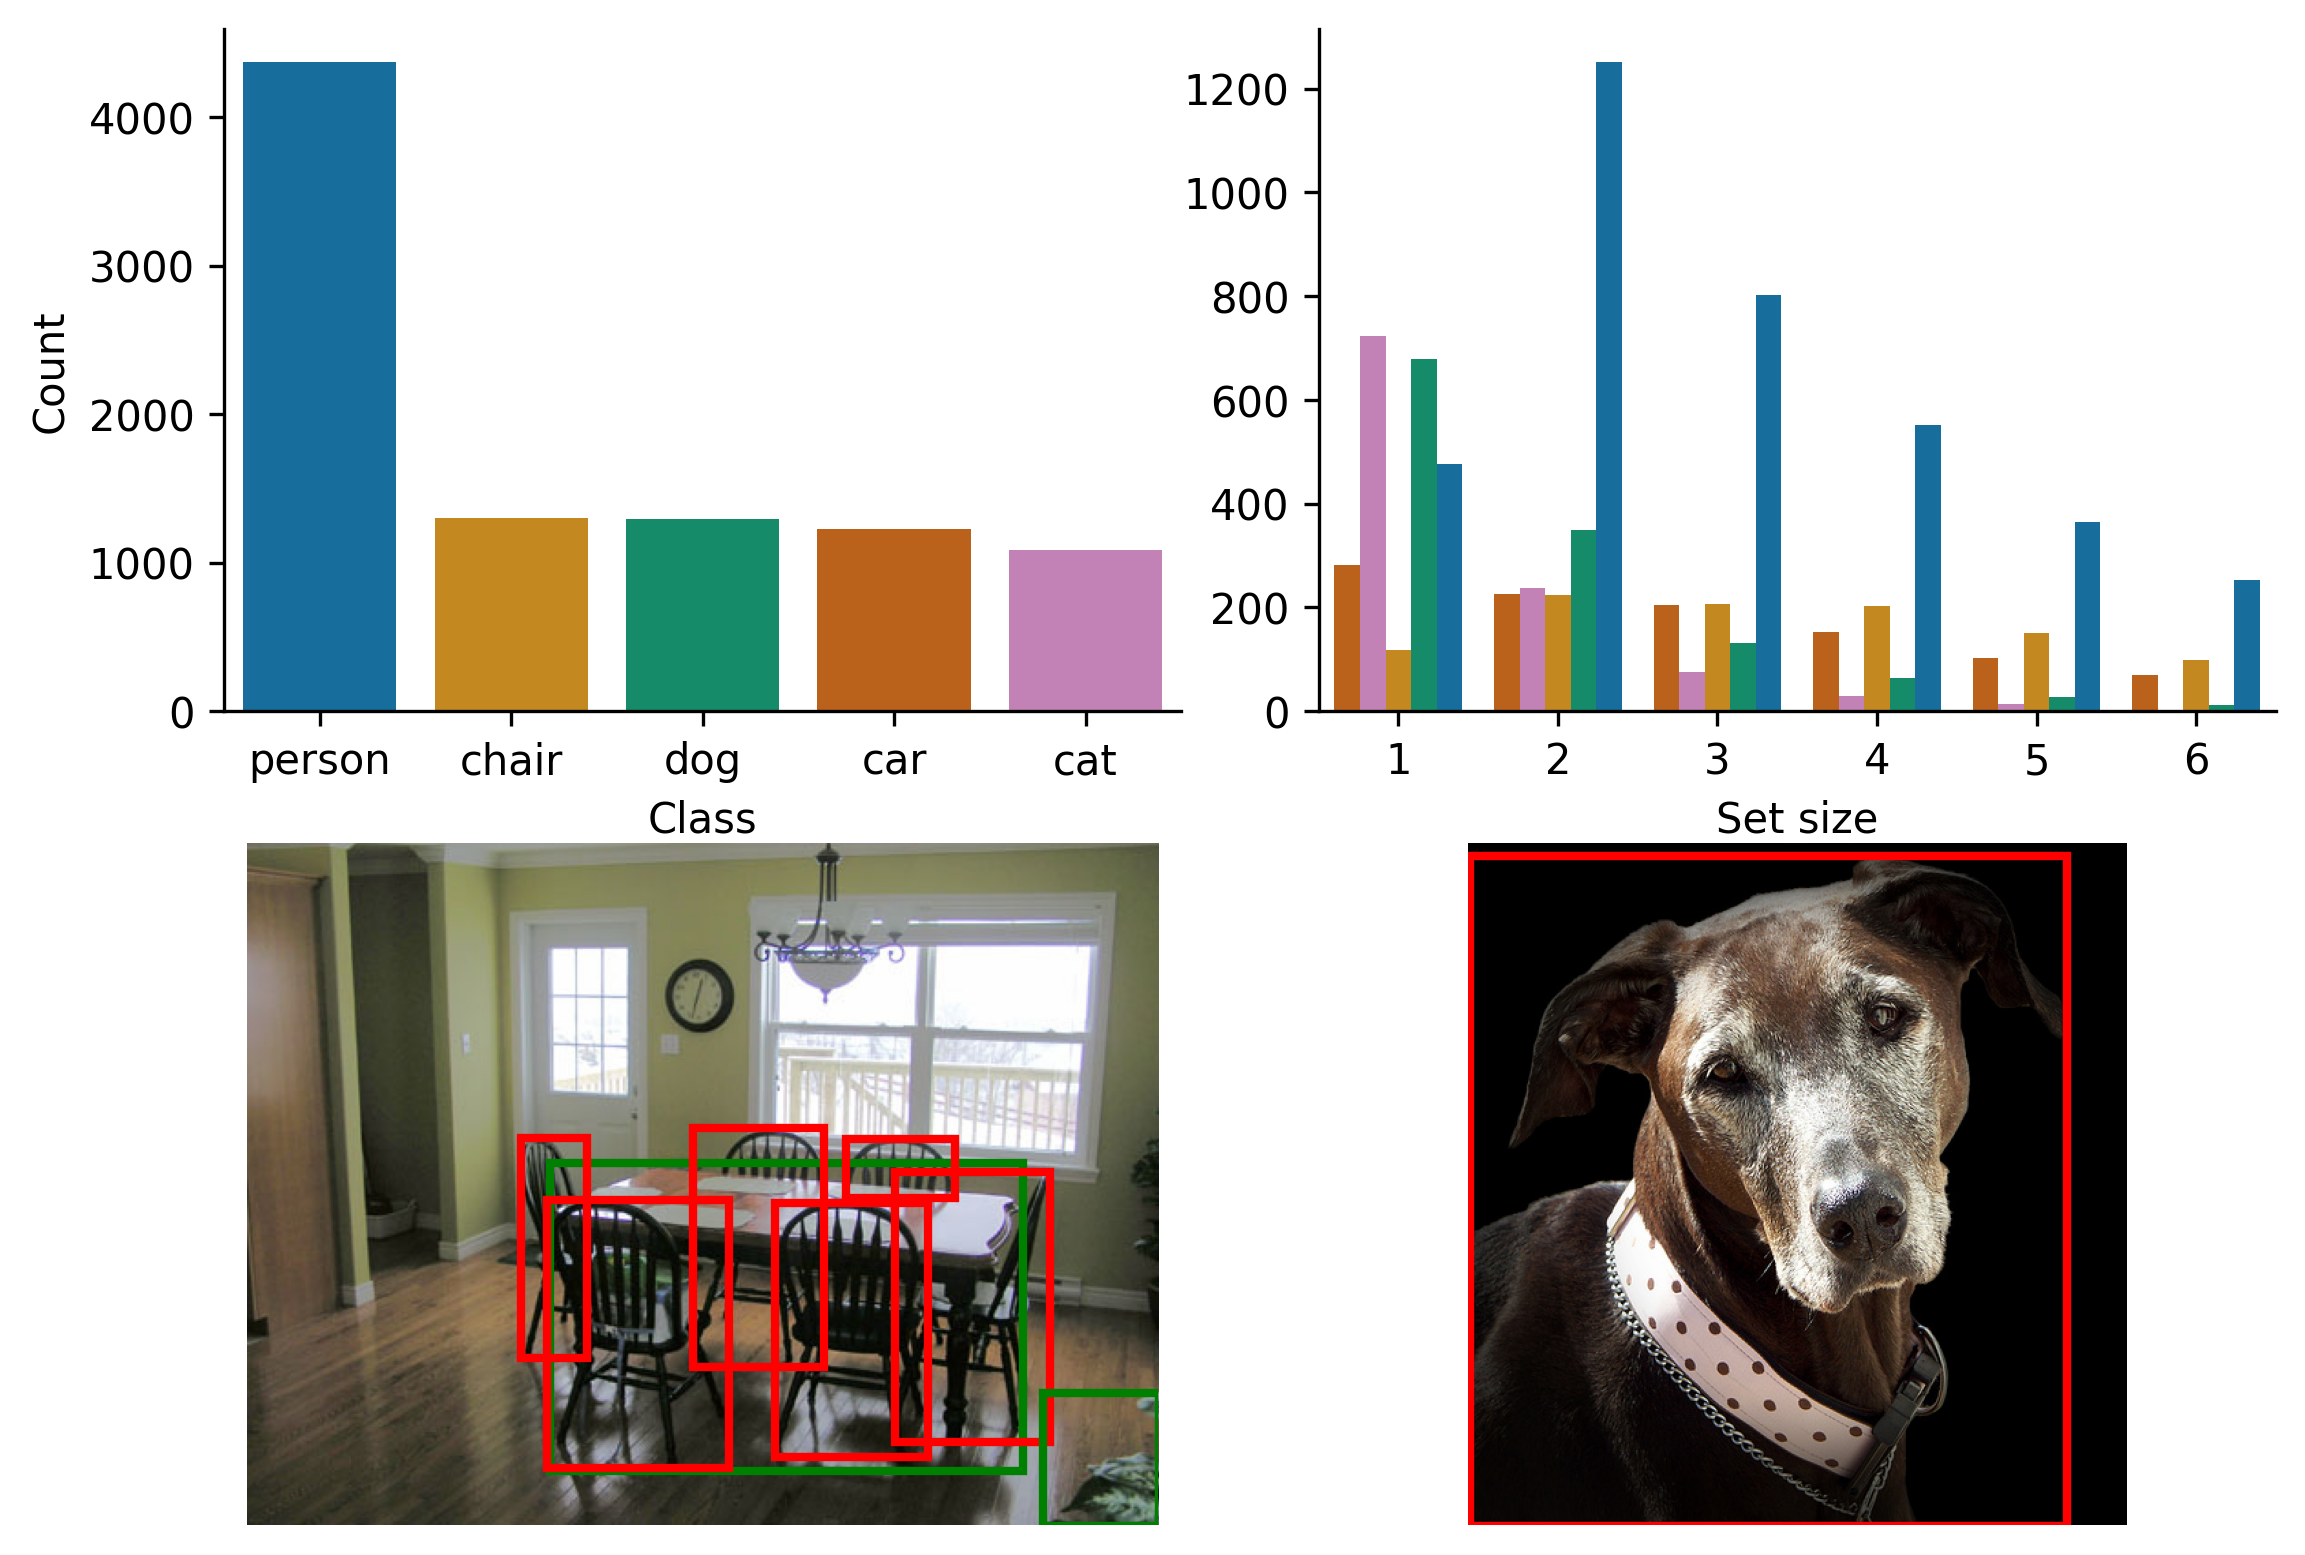

In [19]:
fig, ax_arr = plt.subplots(2, 2, figsize=(7.5, 5), dpi=300)
ax_arr = ax_arr.ravel()

palette = sns.color_palette("colorblind", n_colors=N_CLASSES)
hue_dict = {k:v for k, v in zip(these_class_labels, palette)}

sns.barplot(
    data=df_label_rows,
    order=order[:N_CLASSES],
    x='label_str',
    y='n_rows',
    palette=hue_dict,
    ax=ax_arr[0],
)

ax_arr[0].set_ylabel('Count')
ax_arr[0].set_xlabel('Class')

g = sns.barplot(
    data=data_for_plot,
    x="set_size",
    y="count",
    hue="label_str",
    palette=hue_dict,
    ax=ax_arr[1],
    # order=order[:N_CLASSES],
)
g.legend_.remove()
ax_arr[1].set_ylabel('')
ax_arr[1].set_xlabel('Set size');

for ax in ax_arr[:2]:
    sns.despine(ax=ax)

has_chair = vsd_df['labels_str'].apply(lambda labels_str_list: 'chair' in labels_str_list)
df_chair = vsd_df[has_chair]
IND = 1
vsd_df_row = list(df_chair.itertuples())[IND]
_plot_row(vsd_df_row, ax_arr[2], target_label='chair')
ax_arr[2].set_axis_off()

has_dog = vsd_df['labels_str'].apply(lambda labels_str_list: 'dog' in labels_str_list)
df_dog = vsd_df[has_dog]
IND = 4
vsd_df_row = list(df_dog.itertuples())[IND]
_plot_row(vsd_df_row, ax_arr[3], target_label='dog')
ax_arr[3].set_axis_off()

fig.tight_layout(pad=0.05)

for ext in ('svg', 'png'):
    fig_path = pyprojroot.here().joinpath(
        f'docs/paper/figures/experiment-2/Pascal-VOC-dataset-set-size.{ext}'
    )
    plt.savefig(fig_path, bbox_inches='tight')